# Review Section

In [7]:
import sympy as sp

# 심볼 정의
A, r, n = sp.symbols('A r n', positive=True)
k = sp.symbols('k', integer=True, positive=True)

# ---------- 1) 유한만기: Annuity-immediate (첫 지급 t=1) ----------
# 현재가치
P_n = sp.summation(A/(1+r)**k, (k, 1, n))
P_n = sp.simplify(P_n)  # 닫힌형: A*(1-(1+r)**(-n))/r

# Macaulay Duration (가중평균 만기)
D_n = sp.summation(k*A/(1+r)**k, (k, 1, n)) / P_n
D_n = sp.simplify(D_n)

# Modified Duration
DM_n = sp.simplify(D_n/(1+r))

print("=== Finite n (Annuity-immediate) ===")
print("Present Value P_n      :", P_n)
print("Macaulay Duration D_n  :", D_n)
print("Modified Duration DM_n :", DM_n)
print()

# ---------- 2) 영구연금: Perpetuity (n -> ∞) ----------
P_inf = sp.limit(P_n, n, sp.oo)                      # A/r
D_inf = sp.limit(D_n, n, sp.oo)                      # 1 + 1/r
DM_inf = sp.simplify(D_inf/(1+r))                    # (1 + 1/r)/(1+r)

print("=== Perpetuity (n -> ∞) ===")
print("Present Value P_inf      :", sp.simplify(P_inf))  # A/r
print("Macaulay Duration D_inf  :", sp.simplify(D_inf))  # 1 + 1/r
print("Modified Duration DM_inf :", sp.simplify(DM_inf)) # (1 + 1/r)/(1+r)

# ---------- (선택) 수치 예시 ----------
# 예: A=100, r=5%(0.05), n=12
subs_example = {A: 100, r: sp.Rational(5,100), n: 12}
print("\n=== Numeric example (A=100, r=5%, n=12) ===")
print("P_n  =", sp.N(P_n.subs(subs_example)))
print("D_n  =", sp.N(D_n.subs(subs_example)))
print("DM_n =", sp.N(DM_n.subs(subs_example)))

=== Finite n (Annuity-immediate) ===
Present Value P_n      : A/r - A/(r*(r + 1)**n)
Macaulay Duration D_n  : (-n*r + r*(r + 1)**n - r + (r + 1)**n - 1)/(r*((r + 1)**n - 1))
Modified Duration DM_n : (-n*r + r*(r + 1)**n - r + (r + 1)**n - 1)/(r*(r + 1)*((r + 1)**n - 1))

=== Perpetuity (n -> ∞) ===
Present Value P_inf      : A/r
Macaulay Duration D_inf  : (r + 1)/r
Modified Duration DM_inf : 1/r

=== Numeric example (A=100, r=5%, n=12) ===
P_n  = 886.325163644881
D_n  = 5.92190159500430
DM_n = 5.63990628095648


In [8]:
import numpy as np

def bond_measures(coupon_rate, ytm_annual, maturity_years, freq=4, FV=100.0):
    """
    coupon_rate : 연 쿠폰율 (예: 0.08)
    ytm_annual  : 연 만기수익률 (예: 0.10)  # 복리빈도 freq 기준 명목연수익률
    maturity_years : 만기(년)
    freq        : 쿠폰 지급 빈도(연간 횟수). 분기=4, 반기=2, 월간=12
    FV          : 액면가
    반환: price, macaulay_dur(years), modified_dur(years), convexity(years^2)
    """
    m = freq
    N = int(maturity_years * m)          # 총 지급 횟수
    c = coupon_rate * FV / m             # 회당 쿠폰
    k = np.arange(1, N + 1)              # 1,2,...,N (period index)

    # 현금흐름 벡터
    cf = np.full(N, c, dtype=float)
    cf[-1] += FV

    # 할인계수
    df = (1 + ytm_annual / m) ** k

    # 가격
    price = np.sum(cf / df)

    # Macaulay Duration (년 단위)
    macaulay = np.sum((k / m) * cf / df) / price

    # Modified Duration (년 단위, 연간 금리에 대한 민감도)
    modified = macaulay / (1 + ytm_annual / m)

    # Convexity (년^2, 연간 금리에 대한 민감도)
    # d^2P/dy^2 = sum[ CF_k * (k(k+1)/m^2) / (1+y/m)^(k+2) ]
    convexity = np.sum((k * (k + 1) / m**2) * cf / (1 + ytm_annual / m) ** (k + 2)) / price

    return price, macaulay, modified, convexity


# ---- 문제 조건 ----
price, D_mac, D_mod, Conv = bond_measures(
    coupon_rate=0.08,   # 8%
    ytm_annual=0.10,    # 10%
    maturity_years=3,
    freq=4,             # 분기
    FV=100.0
)

print(f"Price        : {price:.6f}")
print(f"Macaulay Dur : {D_mac:.6f} years")
print(f"Modified Dur : {D_mod:.6f} years")
print(f"Convexity    : {Conv:.6f} years^2")

Price        : 94.871118
Macaulay Dur : 2.686777 years
Modified Dur : 2.621246 years
Convexity    : 8.001327 years^2


### 테슬라 주식과 엔비디아 주식의 2024년 한 해 동안의 종가 데이터를 다운로드 받아 보아라. 

In [3]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

tickers=['TSLA','NVDA']

# 기간 지정
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-12-31', '%Y-%m-%d')


result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'
    # 칼럼 이름 변경
    df.columns = [ticker]

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,NVDA
Date,,
2024-01-02 00:00:00-05:00,248.419998,48.143860
2024-01-03 00:00:00-05:00,238.449997,47.545155
2024-01-04 00:00:00-05:00,237.929993,47.973949
2024-01-05 00:00:00-05:00,237.490005,49.072395
2024-01-08 00:00:00-05:00,240.449997,52.226807
...,...,...
2024-12-23 00:00:00-05:00,430.600006,139.639572
2024-12-24 00:00:00-05:00,462.279999,140.189468
2024-12-26 00:00:00-05:00,454.130005,139.899521


In [27]:
# Excel Sheet으로 보기
# Colab에서는 작동하지 않음
import xlwings as xw

xw.view(result_df)

# pykrx

In [1]:
# pip install pykrx
from pykrx import stock
from pykrx import bond
from datetime import datetime

now = datetime.now()
today_date1 = now.strftime('%Y%m%d')
start_date = '20240101'

C:\ProgramData\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [4]:
# krx 종목리스트
market_list = ['KOSPI', 'KOSDAQ', 'KONEX']

kor_ticker_list_df = pd.DataFrame()
for market_nm in market_list:
    ticker_list = stock.get_market_ticker_list(today_date1, market=market_nm)
    for tickers in ticker_list:
        corp_name = stock.get_market_ticker_name(tickers)
        df = pd.DataFrame({'ticker':tickers,
                           'corp_name':corp_name,
                           'market': market_nm
                          }, index = [0])
        kor_ticker_list_df = pd.concat([kor_ticker_list_df,df])
kor_ticker_list_df = kor_ticker_list_df.reset_index(drop = True)
kor_ticker_list_df.head()

AttributeError: 'Ticker' object has no attribute 'get_market_ticker_list'

In [52]:
xw.view(kor_ticker_list_df)

In [51]:
kor_ticker_list_df.tail(20)

,ticker,corp_name,market
2858,346010,타이드,KONEX
2859,318660,타임기술,KONEX
2860,476710,타조엔터테인먼트,KONEX
2861,434190,탈로스,KONEX
2862,180060,탑선,KONEX
2863,052960,태양3C,KONEX
2864,116100,태양기계,KONEX
2865,308700,테크엔,KONEX
2866,258050,테크트랜스,KONEX
2867,413300,티엘엔지니어링,KONEX


In [49]:
kor_ticker_list_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2878 entries, 0 to 2877
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ticker     2878 non-null   object
 1   corp_name  2878 non-null   object
 2   marke      2878 non-null   object
dtypes: object(3)
memory usage: 67.6+ KB


### 현대차 주식과 KG모빌리언스 주식의 2024년 한 해 동안의 종가 데이터를 다운로드 받아 보아라.

In [57]:
stock.get_market_ohlcv(start_date, end_date, '005380')

,시가,고가,저가,종가,거래량,등락률
날짜,,,,,,
2024-01-02,202000,202500,199800,200500,373050,-1.474201
2024-01-03,199100,199500,193800,193800,548675,-3.341646
2024-01-04,192000,192800,189100,190000,505979,-1.960784
2024-01-05,190100,190500,187200,187300,440219,-1.421053
2024-01-08,187600,188900,185500,185700,323498,-0.854245
...,...,...,...,...,...,...
2024-12-23,212500,216500,212000,215000,468339,2.137767
2024-12-24,215000,217000,213000,216500,351647,0.697674
2024-12-26,217500,219500,215000,217500,460871,0.461894


In [60]:
# 현대차 티커: 005380, KG모빌리언스 티커: 046440

tickers=['005380','046440']
# 기간 지정
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-12-31', '%Y-%m-%d')

result_df = pd.DataFrame()

for ticker in tickers:
    data = stock.get_market_ohlcv(start_date, end_date, ticker)
    df=pd.DataFrame(data['종가'])
    
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    df.index.name = 'Date'
    
    # 칼럼 이름 변경
    df.columns = [ticker]

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,005380,046440
Date,,
2024-01-02,200500,5360
2024-01-03,193800,5430
2024-01-04,190000,5320
2024-01-05,187300,5270
2024-01-08,185700,5310
...,...,...
2024-12-23,215000,4870
2024-12-24,216500,4860
2024-12-26,217500,4880


### 테슬라 주식과 엔비디아 주식의 2024년 한 해 동안의 종가 데이터를 다운로드 받은 후, 각 데이터를 첫 날 데이터로 표준화하여 chart로 그려보아라.

In [29]:
result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 정규화하여 수정주가 칼럼 추가
    df['Adjusted_Close'] = (df['Close'] / ref_price) * 100
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_adj']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,TSLA_adj,NVDA,NVDA_adj
Date,,,,
2024-01-02 00:00:00-05:00,248.419998,100.000000,48.143860,100.000000
2024-01-03 00:00:00-05:00,238.449997,95.986635,47.545158,98.756432
2024-01-04 00:00:00-05:00,237.929993,95.777310,47.973949,99.647078
2024-01-05 00:00:00-05:00,237.490005,95.600196,49.072392,101.928661
2024-01-08 00:00:00-05:00,240.449997,96.791723,52.226810,108.480730
...,...,...,...,...
2024-12-23 00:00:00-05:00,430.600006,173.335484,139.639572,290.046483
2024-12-24 00:00:00-05:00,462.279999,186.088078,140.189468,291.188677
2024-12-26 00:00:00-05:00,454.130005,182.807346,139.899521,290.586424


<Axes: xlabel='Date'>

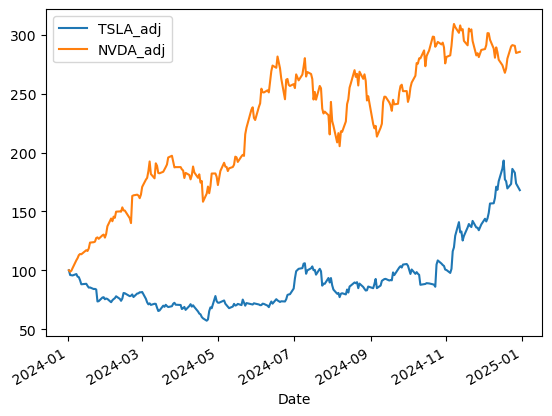

In [30]:
# chart로 그리기
result_df.loc['2024-01':'2024-12',['TSLA_adj','NVDA_adj']].plot()

In [31]:
# 이동평균(Moving Average) 구하기
result_df['TSLA_MA']=result_df.TSLA.rolling(5).mean() # 5개씩 이동평균을 만든다.
result_df['NVDA_MA']=result_df.NVDA.rolling(5).mean() # 5개씩 이동평균을 만든다.
result_df.head(10) # 앞 10개 데이터추출

,TSLA,TSLA_adj,NVDA,NVDA_adj,TSLA_MA,NVDA_MA
Date,,,,,,
2024-01-02 00:00:00-05:00,248.419998,100.000000,48.143860,100.000000,NaN,NaN
2024-01-03 00:00:00-05:00,238.449997,95.986635,47.545158,98.756432,NaN,NaN
2024-01-04 00:00:00-05:00,237.929993,95.777310,47.973949,99.647078,NaN,NaN
2024-01-05 00:00:00-05:00,237.490005,95.600196,49.072392,101.928661,NaN,NaN
2024-01-08 00:00:00-05:00,240.449997,96.791723,52.226810,108.480730,240.547998,48.992434
2024-01-09 00:00:00-05:00,234.960007,94.581760,53.113373,110.322215,237.856000,49.986337
2024-01-10 00:00:00-05:00,233.940002,94.171163,54.322765,112.834254,236.954001,51.341858
2024-01-11 00:00:00-05:00,227.220001,91.466067,54.794521,113.814143,234.812003,52.705972
2024-01-12 00:00:00-05:00,218.889999,88.112874,54.682579,113.581626,231.092001,53.828010


<Axes: xlabel='Date'>

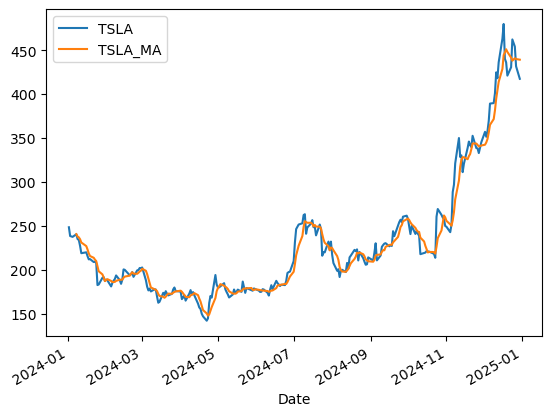

In [32]:
# chart로 그리기
result_df.loc['2024-01':'2024-12',['TSLA','TSLA_MA']].plot()

In [33]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2024-01-02 00:00:00-05:00 to 2024-12-30 00:00:00-05:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   TSLA      251 non-null    float64
 1   TSLA_adj  251 non-null    float64
 2   NVDA      251 non-null    float64
 3   NVDA_adj  251 non-null    float64
 4   TSLA_MA   247 non-null    float64
 5   NVDA_MA   247 non-null    float64
dtypes: float64(6)
memory usage: 21.8 KB


In [34]:
# 월간 데이터 추출

TSLA_ohlc=result_df['TSLA'].resample('ME').ohlc()
TSLA_ohlc

,open,high,low,close
Date,,,,
2024-01-31 00:00:00-05:00,248.419998,248.419998,182.630005,187.289993
2024-02-29 00:00:00-05:00,188.860001,202.039993,181.059998,201.880005
2024-03-31 00:00:00-04:00,202.639999,202.639999,162.500000,175.789993
2024-04-30 00:00:00-04:00,175.220001,194.050003,142.050003,183.279999
2024-05-31 00:00:00-04:00,179.990005,186.600006,168.470001,178.080002
2024-06-30 00:00:00-04:00,176.289993,197.880005,170.660004,197.880005
2024-07-31 00:00:00-04:00,209.860001,263.260010,209.860001,232.070007
2024-08-31 00:00:00-04:00,216.860001,223.270004,191.759995,214.110001
2024-09-30 00:00:00-04:00,210.600006,261.630005,210.600006,261.630005


In [35]:
# 분기 데이터 추출

TSLA_Quaterly=result_df['TSLA'].resample('QE').ohlc()
TSLA_Quaterly

,open,high,low,close
Date,,,,
2024-03-31 00:00:00-04:00,248.419998,248.419998,162.500000,175.789993
2024-06-30 00:00:00-04:00,175.220001,197.880005,142.050003,197.880005
2024-09-30 00:00:00-04:00,209.860001,263.260010,191.759995,261.630005
2024-12-31 00:00:00-05:00,258.019989,479.859985,213.649994,417.410004


### 테슬라 주식과 엔비디아 주식의 2024년 한 해 동안의 종가 데이터를 다운로드 받은 후, 각 주가에 대한 로그리턴 데이터 칼럼을 생성해 보아라.

In [62]:
import numpy as np

result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 로그 리턴 데이터 생상
    df['Return']=np.log(df['Close'])-np.log(df['Close'].shift(1))
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_return']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,TSLA_return,NVDA,NVDA_return
Date,,,,
2024-01-02 00:00:00-05:00,248.419998,NaN,48.143860,NaN
2024-01-03 00:00:00-05:00,238.449997,-0.040961,47.545158,-0.012514
2024-01-04 00:00:00-05:00,237.929993,-0.002183,47.973949,0.008978
2024-01-05 00:00:00-05:00,237.490005,-0.001851,49.072392,0.022638
2024-01-08 00:00:00-05:00,240.449997,0.012387,52.226810,0.062299
...,...,...,...,...
2024-12-23 00:00:00-05:00,430.600006,0.022404,139.639572,0.036232
2024-12-24 00:00:00-05:00,462.279999,0.070991,140.189468,0.003930
2024-12-26 00:00:00-05:00,454.130005,-0.017787,139.899521,-0.002070


### 테슬라 주식의 2024년 한 해 동안의 daily 수익율 데이터 칼럼을 바탕으로 수익율의 평균, 분산, 표준편차를 구하고 이를 연간데이터로 환산해 보아라.

In [100]:
import numpy as np

Daily_return=result_df.TSLA_return

# Daily 수익율의 평균, 분산, 표준편차
Daily_mean=np.mean(Daily_return)*100
Daily_var=np.var(Daily_return)
Daily_std=np.std(Daily_return)

print('Daily mean:{:.4f}%'.format(Daily_mean))
print('Daily variance:{:.4f}'.format(Daily_var))
print('Daily standard deviation:{:.4f}'.format(Daily_std))

Daily mean:0.2076%
Daily variance:0.0016
Daily standard deviation:0.0394


In [99]:
# Monthly return
TSLA_monthly=result_df['TSLA'].resample('ME').ohlc()[['close']]
# 로그 리턴 데이터 생상
TSLA_monthly['Return']=np.log(TSLA_monthly['close'])-np.log(TSLA_monthly['close'].shift(1))

# Monthy 수익율의 평균, 분산, 표준편차
print('Monthly mean:{:.4f}%'.format(np.mean(TSLA_monthly.Return)*100))
print('Monthly variance:{:.4f}'.format(np.var(TSLA_monthly.Return)))
print('Monthly standard deviation:{:.4f}'.format(np.std(TSLA_monthly.Return)))

Monthly mean:7.2856%
Monthly variance:0.0177
Monthly standard deviation:0.1331


In [101]:
# Monthy 수익율의 평균, 분산, 표준편차 추정
print('Monthly mean:{:.4f}%'.format(Daily_mean*20))
print('Monthly variance:{:.4f}'.format(Daily_var*20))
print('Monthly standard deviation:{:.4f}'.format(Daily_std*np.sqrt(20)))

Monthly mean:4.1516%
Monthly variance:0.0310
Monthly standard deviation:0.1761


In [109]:
# Annual 수익율의 평균, 분산, 표준편차 추정
print('Annual mean:{:.4f}%'.format(Daily_mean*252))
print('Annual variance:{:.4f}'.format(Daily_var*252))
print('Annual standard deviation:{:.4f}'.format(Daily_std*np.sqrt(252)))

Annual mean:-15.8400%
Annual variance:0.0264
Annual standard deviation:0.1625


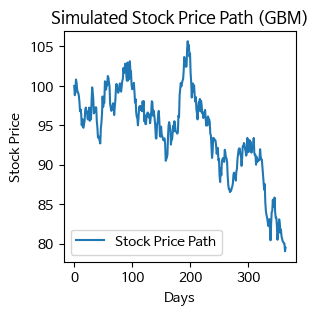

In [102]:
# 주가 path 생성
import numpy as np
import matplotlib.pyplot as plt

# 파라미터 설정
S0 = 100    # 초기 주가
r = 0.05    # 무위험 이자율
sigma = 0.2 # 변동성
T = 1       # 기간 (년)
N = 365     # 시뮬레이션 일수 (하루 단위)
dt = T / N  # 시간 간격

# 주가 경로 생성
np.random.seed(111)
W = np.random.randn(N)  # 표준 정규분포 난수
S = np.zeros(N+1)  
S[0] = S0

for t in range(1, N+1):
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt\
                           + sigma * np.sqrt(dt) * W[t-1])

# 결과 시각화
plt.figure(figsize=(3,3))
plt.plot(S, label="Stock Price Path")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Simulated Stock Price Path (GBM)")
plt.legend()
plt.show()

In [104]:
import pandas as pd

# 날짜 인덱스 생성 (시작일 임의로 설정)
dates = pd.date_range(start="2024-01-01", periods=N+1, freq="D")

# DataFrame 생성
df = pd.DataFrame({"Price": S}, index=dates)

# 월말 종가만 추출
monthly = df.resample("ME").last()
print(monthly)

                 Price
2024-01-31   98.206010
2024-02-29  101.064340
2024-03-31  101.338510
2024-04-30   98.077679
2024-05-31   93.882139
2024-06-30   96.033794
2024-07-31   96.509901
2024-08-31   93.099764
2024-09-30   87.270551
2024-10-31   92.800283
2024-11-30   82.883718
2024-12-31   79.498788


In [106]:
# 로그 리턴 데이터 생상
df['Return']=np.log(df['Price'])-np.log(df['Price'].shift(1))
Daily_return=df.Return

# Daily 수익율의 평균, 분산, 표준편차
Daily_mean=np.mean(Daily_return)*100
Daily_var=np.var(Daily_return)
Daily_std=np.std(Daily_return)

print('Daily mean:{:.4f}%'.format(Daily_mean))
print('Daily variance:{:.4f}'.format(Daily_var))
print('Daily standard deviation:{:.4f}'.format(Daily_std))

Daily mean:-0.0629%
Daily variance:0.0001
Daily standard deviation:0.0102


In [107]:
# Monthly return
monthly['Return']=np.log(monthly['Price'])-np.log(monthly['Price'].shift(1))

# Monthy 수익율의 평균, 분산, 표준편차
print('Monthly mean:{:.4f}%'.format(np.mean(monthly.Return)*100))
print('Monthly variance:{:.4f}'.format(np.var(monthly.Return)))
print('Monthly standard deviation:{:.4f}'.format(np.std(monthly.Return)))

Monthly mean:-1.9211%
Monthly variance:0.0022
Monthly standard deviation:0.0468


In [108]:
# Monthy 수익율의 평균, 분산, 표준편차 추정
print('Monthly mean:{:.4f}%'.format(Daily_mean*30))
print('Monthly variance:{:.4f}'.format(Daily_var*30))
print('Monthly standard deviation:{:.4f}'.format(Daily_std*np.sqrt(30)))

Monthly mean:-1.8857%
Monthly variance:0.0031
Monthly standard deviation:0.0561


In [38]:
result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 로그 리턴 데이터 생상
    df['Return']=np.log(df['Close'])-np.log(df['Close'].shift(1))
    
    # 변동성(volatility) 데이터 생성
    df['Volatility_6M'] = df['Return'].rolling(window=126).std() * np.sqrt(252)
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_return',ticker+'_6MVol']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)


result_df

,TSLA,TSLA_return,TSLA_6MVol,NVDA,NVDA_return,NVDA_6MVol
Date,,,,,,
2024-01-02 00:00:00-05:00,248.419998,NaN,NaN,48.143860,NaN,NaN
2024-01-03 00:00:00-05:00,238.449997,-0.040961,NaN,47.545158,-0.012514,NaN
2024-01-04 00:00:00-05:00,237.929993,-0.002183,NaN,47.973949,0.008978,NaN
2024-01-05 00:00:00-05:00,237.490005,-0.001851,NaN,49.072392,0.022638,NaN
2024-01-08 00:00:00-05:00,240.449997,0.012387,NaN,52.226810,0.062299,NaN
...,...,...,...,...,...,...
2024-12-23 00:00:00-05:00,430.600006,0.022404,0.699054,139.639572,0.036232,0.525509
2024-12-24 00:00:00-05:00,462.279999,0.070991,0.702660,140.189468,0.003930,0.525522
2024-12-26 00:00:00-05:00,454.130005,-0.017787,0.703518,139.899521,-0.002070,0.524760


### 테슬라 주식과 엔비디아 주식의 2024년 한 해 동안의 종가 기준 로그리턴 데이터 칼럼을 만든 후, 6개월 상관계수 데이터를 만들어 보아라. 

In [41]:
result_df = pd.DataFrame()

for ticker in tickers:
    stock = yf.Ticker(ticker)
    data = stock.history(start=start_date, end=end_date)
    df=pd.DataFrame(data['Close'])
    # 날짜 인덱스 설정
    df.index = pd.to_datetime(df.index)
    # 기준일의 종가(값이 없을 시 직전 영업일 값으로)
    ref_price = df['Close'].iloc[0]
    # 로그 리턴 데이터 생상
    df['Return']=np.log(df['Close'])-np.log(df['Close'].shift(1))
    # 칼럼 이름 변경
    df.columns = [ticker,ticker+'_return']

    if df is not np.nan:
        result_df = pd.concat([result_df, df], axis=1)

# 6개월 상관계수 만들기
result_df['TSLA_NVDA_corr'] = (
    result_df['TSLA_return']
    .rolling(126)
    .corr(result_df['NVDA_return'])
)

result_df

,TSLA,TSLA_return,NVDA,NVDA_return,TSLA_NVDA_corr
Date,,,,,
2024-01-02 00:00:00-05:00,248.419998,NaN,48.143860,NaN,NaN
2024-01-03 00:00:00-05:00,238.449997,-0.040961,47.545158,-0.012514,NaN
2024-01-04 00:00:00-05:00,237.929993,-0.002183,47.973949,0.008978,NaN
2024-01-05 00:00:00-05:00,237.490005,-0.001851,49.072392,0.022638,NaN
2024-01-08 00:00:00-05:00,240.449997,0.012387,52.226810,0.062299,NaN
...,...,...,...,...,...
2024-12-23 00:00:00-05:00,430.600006,0.022404,139.639572,0.036232,0.390901
2024-12-24 00:00:00-05:00,462.279999,0.070991,140.189468,0.003930,0.389617
2024-12-26 00:00:00-05:00,454.130005,-0.017787,139.899521,-0.002070,0.389953


In [43]:
# 특정 시점에서 상관계수 행렬 출력하기
window = 126
returns = result_df[[c for c in result_df.columns if c.endswith('_return')]]

rolling_corrs = returns.rolling(window).corr()

# 특정 시점의 상관행렬 예시
print(rolling_corrs.loc['2024-12-30'])

             TSLA_return  NVDA_return
TSLA_return     1.000000     0.392366
NVDA_return     0.392366     1.000000


In [110]:
np.log(2)

0.6931471805599453

In [4]:
from sympy import oo,limit,symbols,summation

r,A=symbols('r A',positive=True)
n,k=symbols('n k',integer=True, positive=True)

P=limit(summation(A/(1+r)**k,(k,1,n)),n,oo)
D=(1/P)*limit(summation(k*A/(1+r)**k,(k,1,n)),n,oo)
DM=D/(1+r)
print('Annuity Value:',P)
print('Macaulay Duration:',D)
print('Modified Duration:',DM)

Annuity Value: A/r
Macaulay Duration: r*(A/r + A/r**2)/A
Modified Duration: r*(A/r + A/r**2)/(A*(r + 1))


In [3]:
D.simplify()

(r + 1)/r

In [5]:
DM.simplify()

1/r

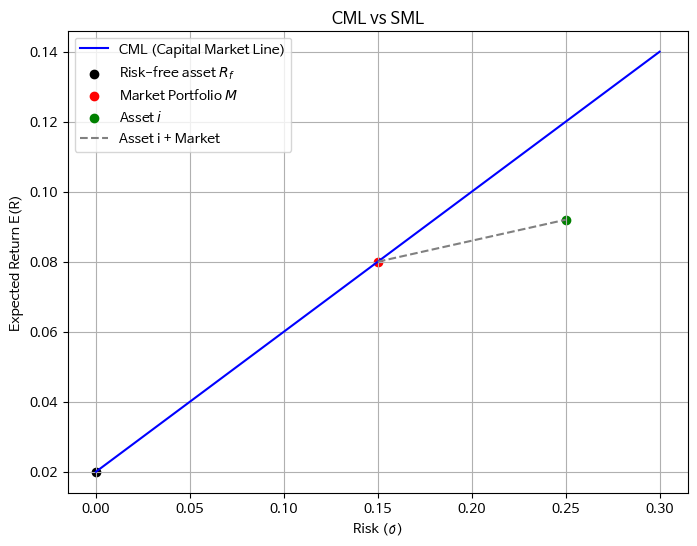

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 무위험 수익률, 시장 기대수익률, 시장 표준편차
Rf = 0.02
Rm = 0.08
sigma_m = 0.15

# CML 직선 방정식
def CML(sigma):
    return Rf + (Rm - Rf) / sigma_m * sigma

# sigma 범위
sigma = np.linspace(0, 0.3, 100)

# 예시 개별 자산
sigma_i = 0.25
beta_i = 1.2
Ri = Rf + beta_i * (Rm - Rf)  # CAPM 기대수익률

# 그림 그리기
plt.figure(figsize=(8,6))

# CML
plt.plot(sigma, CML(sigma), label="CML (Capital Market Line)", color="blue")

# 무위험 수익률 표시
plt.scatter(0, Rf, color="black", label="Risk-free asset $R_f$")

# 시장 포트폴리오 표시
plt.scatter(sigma_m, Rm, color="red", label="Market Portfolio $M$")

# 개별 자산 표시
plt.scatter(sigma_i, Ri, color="green", label="Asset $i$")

# 자산 i와 시장을 잇는 직선 (SML 개념 아님, 포트폴리오 조합선)
plt.plot([sigma_m, sigma_i], [Rm, Ri], linestyle="--", color="gray", label="Asset i + Market")

plt.xlabel("Risk (σ)")
plt.ylabel("Expected Return E(R)")
plt.title("CML vs SML")
plt.legend()
plt.grid(True)
plt.show()